In [1]:
import os
import tensorflow as tf
import keras
import numpy as np
import cv2 as cv
import random
import matplotlib.pyplot as plt

In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="VdwBRxsJsFmCMW94xJjd")
project = rf.workspace("object-detection-yolov5").project("plate_ocr_ir")
dataset = project.version(2).download("folder")

In [2]:
train_path = "/content/plate_ocr_ir-2/train"
valid_path = "/content/plate_ocr_ir-2/valid"
test_path = "/content/plate_ocr_ir-2/test"

In [3]:
class_names = subdirs = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'ch', 'd', 'ein', 'f', 'g', 'ghaf', 'ghein', 'h2', 'hj', 'j', 'k', 'kh', 'l', 'm', 'n', 'p', 'r', 's', 'sad', 'sh', 't', 'ta', 'th', 'v', 'y', 'z', 'za', 'zad', 'zal', 'zh']
num_classes = len(class_names)

In [4]:
labels_nums = [i for i in range(0,len(class_names))]
print(labels_nums)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41]


In [5]:
input_img_size = 40

In [6]:
train_imgs = []
train_labels = []
for indx, subdir in enumerate(subdirs):
  imgfolder = os.path.join(train_path, subdir)
  for imgname in os.listdir(imgfolder):
    img = cv.imread(os.path.join(imgfolder, imgname), 0)
    img = cv.resize(img, (input_img_size,input_img_size), interpolation = cv.INTER_AREA)
    train_imgs.append(img)
    train_labels.append(labels_nums[indx])

c = list(zip(train_imgs, train_labels))
random.shuffle(c)
train_imgs, train_labels = zip(*c)

train_images = np.array(train_imgs)
train_labels = np.array(train_labels)

In [7]:
valid_imgs = []
valid_labels = []
for indx, subdir in enumerate(subdirs):
  imgfolder = os.path.join(valid_path, subdir)
  if os.path.exists(imgfolder):
    for imgname in os.listdir(imgfolder):
      img = cv.imread(os.path.join(imgfolder, imgname), 0)
      img = cv.resize(img, (input_img_size,input_img_size), interpolation = cv.INTER_AREA)
      valid_imgs.append(img)
      valid_labels.append(labels_nums[indx])

c = list(zip(valid_imgs, valid_labels))
random.shuffle(c)
valid_imgs, valid_labels = zip(*c)

test_images = np.array(valid_imgs)
test_labels = np.array(valid_labels)

za
38


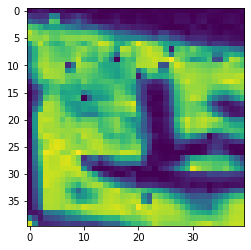

In [8]:
num=40
print(class_names[train_labels[num]])
print(train_labels[num])
plt.imshow(train_images[num])

In [9]:
test_labels.shape

(792,)

In [10]:
train_labels.shape

(8337,)

In [11]:
train_images = train_images / 255.0
test_images = test_images / 255.0

In [87]:
import math
def scheduler(epoch, lr):
  if epoch < 10:
    return lr
  else:
    return lr * math.exp(-0.01)

#Add Callbacks, e.g. ModelCheckpoints, earlystopping, csvlogger.
from keras.callbacks import LearningRateScheduler

callbacks_list = [LearningRateScheduler(scheduler)]

In [88]:
#Add Callbacks, e.g. ModelCheckpoints, earlystopping, csvlogger.
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger

#ModelCheckpoint callback saves a model at some interval. 

#Give unique name to save all models as accuracy improves
filepath="/content/saved_models/weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5" #File name includes epoch and validation accuracy.

#Overwrite the model each time accuracy improves. Saves a lot of space. 
#filepath="/content/drive/MyDrive/Colab Notebooks/saved_models/best_model.hdf5" #File name includes epoch and validation accuracy.
#Use Mode = max for accuracy and min for loss. 
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

#https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=1)
#This callback will stop the training when there is no improvement in
# the validation loss for three consecutive epochs.

#CSVLogger logs epoch, accuracy, loss, val_accuracy, val_loss. So we can plot later.
log_csv = CSVLogger('/content/drive/MyDrive/Colab Notebooks/saved_logs/my_logs.csv', separator=',', append=False)

callbacks_list = [checkpoint, LearningRateScheduler(scheduler)]

In [89]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout

tf.random.set_seed(13)
model = Sequential()
model.add(Conv2D(filters = 16, kernel_size=(7,7), activation='relu', input_shape = (input_img_size,input_img_size,1), kernel_initializer='he_normal'))
model.add(Conv2D(filters = 12, kernel_size=(7,7), activation='relu', kernel_initializer='he_normal'))
model.add(Dropout(0.3))
model.add(Conv2D(filters = 8, kernel_size=(5,5), activation='relu', kernel_initializer='he_normal'))
model.add(Dropout(0.3))

model.add(Conv2D(filters = 8, kernel_size=(3,3), activation='relu', kernel_initializer='he_normal'))
model.add(Dropout(0.3))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(512, activation='relu', kernel_initializer='he_normal'))
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu', kernel_initializer='he_normal'))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu', kernel_initializer='he_normal'))
model.add(Dense(num_classes, activation = 'softmax'))

In [90]:
model.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_85 (Conv2D)          (None, 34, 34, 16)        800       
                                                                 
 conv2d_86 (Conv2D)          (None, 28, 28, 12)        9420      
                                                                 
 dropout_115 (Dropout)       (None, 28, 28, 12)        0         
                                                                 
 conv2d_87 (Conv2D)          (None, 24, 24, 8)         2408      
                                                                 
 dropout_116 (Dropout)       (None, 24, 24, 8)         0         
                                                                 
 conv2d_88 (Conv2D)          (None, 22, 22, 8)         584       
                                                                 
 dropout_117 (Dropout)       (None, 22, 22, 8)       

In [91]:
tf.random.set_seed(13)
opt = tf.keras.optimizers.Adam(learning_rate=4e-4)
model.compile(loss = 'sparse_categorical_crossentropy', optimizer = opt , metrics = ['accuracy'])
hist = model.fit(train_images, train_labels, epochs=100, validation_data=(test_images, test_labels), callbacks = callbacks_list)

Epoch 1/100
253/261 [============================>.] - ETA: 0s - loss: 3.5173 - accuracy: 0.0803
Epoch 1: val_accuracy improved from -inf to 0.37121, saving model to /content/saved_models/weights-improvement-01-0.37.hdf5
261/261 [==============================] - 61s 8ms/step - loss: 3.5028 - accuracy: 0.0835 - val_loss: 2.7875 - val_accuracy: 0.3712 - lr: 4.0000e-04
Epoch 2/100
257/261 [============================>.] - ETA: 0s - loss: 2.5799 - accuracy: 0.2765
Epoch 2: val_accuracy improved from 0.37121 to 0.56439, saving model to /content/saved_models/weights-improvement-02-0.56.hdf5
261/261 [==============================] - 2s 6ms/step - loss: 2.5755 - accuracy: 0.2778 - val_loss: 1.7380 - val_accuracy: 0.5644 - lr: 4.0000e-04
Epoch 3/100
254/261 [============================>.] - ETA: 0s - loss: 1.9454 - accuracy: 0.4219
Epoch 3: val_accuracy improved from 0.56439 to 0.67803, saving model to /content/saved_models/weights-improvement-03-0.68.hdf5
261/261 [=========================

In [92]:
predictions = model.predict(test_images)

25/25 [==============================] - 0s 3ms/step


In [93]:
model.save('saved_model/simple_ocr_plates_model')

In [94]:
!zip -r /content/saved_model/simple_ocr_plates_model.zip /content/saved_model/simple_ocr_plates_model

  adding: content/saved_model/simple_ocr_plates_model/ (stored 0%)
  adding: content/saved_model/simple_ocr_plates_model/fingerprint.pb (stored 0%)
  adding: content/saved_model/simple_ocr_plates_model/assets/ (stored 0%)
  adding: content/saved_model/simple_ocr_plates_model/saved_model.pb (deflated 89%)
  adding: content/saved_model/simple_ocr_plates_model/variables/ (stored 0%)
  adding: content/saved_model/simple_ocr_plates_model/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: content/saved_model/simple_ocr_plates_model/variables/variables.index (deflated 66%)
  adding: content/saved_model/simple_ocr_plates_model/keras_metadata.pb (deflated 93%)


In [95]:
from tensorflow import keras
ocr_model = keras.models.load_model('/content/saved_models/weights-improvement-78-0.97.hdf5')

In [97]:
test_imgs = []
test_labels = []
for indx, subdir in enumerate(subdirs):
  imgfolder = os.path.join(test_path, subdir)
  if os.path.exists(imgfolder):
    for imgname in os.listdir(imgfolder):
      img = cv.imread(os.path.join(imgfolder, imgname), 0)
      img = cv.resize(img, (input_img_size,input_img_size), interpolation = cv.INTER_AREA)
      test_imgs.append(img)
      test_labels.append(labels_nums[indx])

c = list(zip(test_imgs, test_labels))
random.shuffle(c)
test_imgs, test_labels = zip(*c)

test_images = np.array(test_imgs)
test_labels = np.array(test_labels)

In [98]:
test_images.shape

(398, 40, 40)

In [99]:
predictions = ocr_model.predict(test_images)

13/13 [==============================] - 0s 8ms/step


2
2


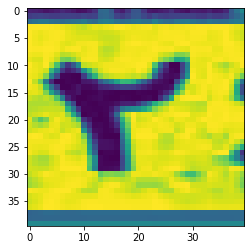

In [100]:
num= np.random.randint(0, len(test_images)-1)
print(class_names[np.argmax(predictions[num])])
print(np.argmax(predictions[num]))
plt.imshow(test_images[num])

13/13 [==============================] - 0s 2ms/step


Text(69.0, 0.5, 'Truth')

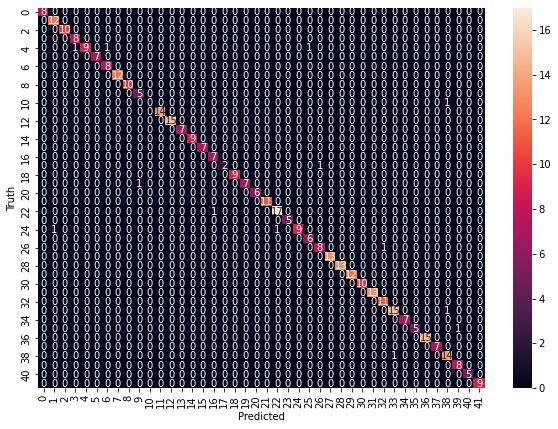

In [102]:
y_predicted = model.predict(test_images)
y_predicted_labels = [np.argmax(i) for i in y_predicted]

cm = tf.math.confusion_matrix(labels=test_labels, predictions=y_predicted_labels)

import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
     

13/13 [==============================] - 0s 2ms/step


Text(69.0, 0.5, 'Truth')

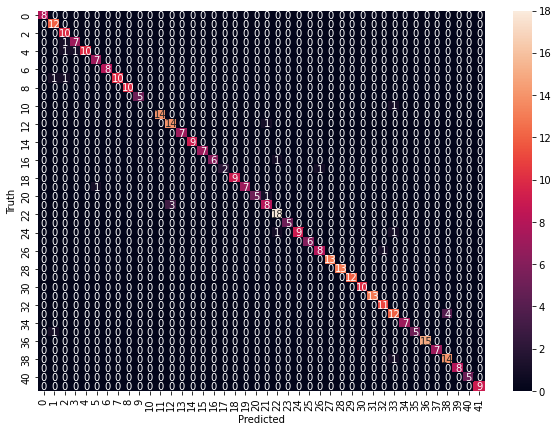

In [ ]:
y_predicted = model.predict(test_images)
y_predicted_labels = [np.argmax(i) for i in y_predicted]

cm = tf.math.confusion_matrix(labels=test_labels, predictions=y_predicted_labels)

import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

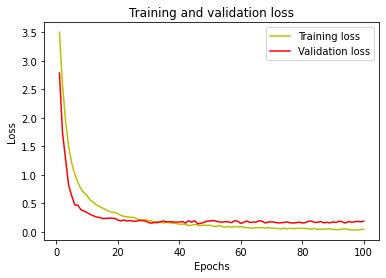

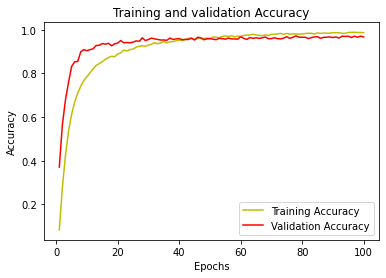

In [103]:
###
#plot the training and validation accuracy and loss at each epoch
loss = hist.history['loss']
val_loss = hist.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()